# Fitting Pure component data

The purpose of this notebook is to show how to fit the molecular parameters of a fluid using SGTPy. First, it is necessary to import the necessary modules and functions, this includes SciPy's ``minimize`` function.

This notebook will fit n-Hexane molecular parameters.

In [1]:
import numpy as np
from scipy.optimize import minimize
from SGTPy import component, saftvrmie
import matplotlib.pyplot as plt

To fit molecular parameters for SAFT models, at least the saturation pressure and liquid density of the fluid is necessary. 
When available, it is recommended to include thermal derived properties as vaporization enthalpies and speed of sound, these can be obtained from several databases such as NIST WebBook, TDE, Detherm, DIPPR 801.

In [2]:
# Experimental data for hexane obtained from NIST WebBook
Tsat = np.array([290., 300., 310., 320., 330., 340., 350., 360.]) # K
Psat = np.array([ 14016.,  21865.,  32975.,  48251.,  68721.,  95527., 129920., 173260.]) # Pa
rhol = np.array([7683.6, 7577.4, 7469.6, 7360.1, 7248.7, 7135. , 7018.7, 6899.5]) # mol/m3
rhov = np.array([ 5.8845,  8.9152, 13.087, 18.683, 26.023, 35.466, 47.412, 62.314]) #mol/m3
#speed of sound
speed_liq = np.array([1090.6, 1047.6, 1005.1,  963.05,  921.37,  880.,  838.85, 797.86])  # m/s
speed_vap = np.array([170.71, 172.79, 174.62, 176.17, 177.42, 178.33, 178.87, 179.01])  # m/s
# enthalpies
Hl = np.array([-10427., -8496.9, -6530.1, -4525., -2480., -393.68, 1735.3, 3908.5]) # J/mol
Hv = np.array([21525., 22893., 24285., 25699., 27135., 28589., 30062., 31549.]) #J/mol
Hvap = Hv - Hl
# interfacial tension
iftexp = np.array([18.842, 17.746, 16.665, 15.6  , 14.549, 13.516, 12.499, 11.5  ])  # mN/m 

Depending on the available experimental data you can write your own objective function. Using this approach you can set the molecular parameters to be fitted and the ones that you want to fix (for example ``lambda_a=6`` or set ``ms`` as a whole number).

You can use the ``saftvrmie`` method to compute the EoS predicted value and then measure its error against the experimental data. Some useful method to be used are:

- ``eos.psat``: computes saturation pressure and densities at given temperature
- ``eos.density``: computes density at given temperature, pressure and aggregation state (L or V).
- ``eos.EnthalpyR``: computes residual enthalpy at given temperature, pressure and aggregation state (L or V).
- ``eos.speed_sound``:computes speed of sound at given temperature, pressure and aggregation state (L or V).

**note**: if you want to use the speed of sounds in your objective function you need to provide the molar weight of the fluid and the ideal gas heat capacities. These can be computed from correlations such as the ones provided by DIPPR 801.

Examples of objectives functions are shown below:

In [3]:
# objective function to optimize molecular parameters
def fobj(inc):
    ms, sigma, eps, lambda_r = inc
    pure = component(ms = ms, sigma = sigma , eps = eps, lambda_r = lambda_r , lambda_a = 6., Mw = 86.18)
    eos = saftvrmie(pure)
    
    #Pure component pressure and liquid density
    P = np.zeros_like(Psat) 
    vl = np.zeros_like(rhol)
    vv = np.zeros_like(rhov)
    n= len(Psat)
    for i in range(n):
        P[i], vl[i], vv[i] = eos.psat(Tsat[i], Psat[i])
    
    rhosaftl = 1/vl
    rhosaftv = 1/vv
    
    # error for saturation pressure and densities
    error = np.mean(np.abs(P/Psat - 1))
    error += np.mean(np.abs(rhosaftl/rhol - 1))
    error += 0.1*np.mean(np.abs(rhosaftv/rhov - 1))
    
    return error

In [4]:
# objective function to optimize molecular parameters
def fobj2(inc):
    ms, sigma, eps, lambda_r = inc
    pure = component(ms = ms, sigma = sigma , eps = eps, lambda_r = lambda_r , lambda_a = 6., Mw = 86.18)
    eos = saftvrmie(pure)
    #Pure component pressure and liquid density
    P = np.zeros_like(Psat) 
    vl = np.zeros_like(rhol)
    vv = np.zeros_like(rhov)
    
    Hrl = np.zeros_like(Hvap)
    Hrv = np.zeros_like(Hvap)
    
    n= len(Psat)
    for i in range(n):
        P[i], vl[i], vv[i] = eos.psat(Tsat[i], Psat[i])
        Hrl[i] = eos.EnthalpyR(Tsat[i], P[i], 'L', v0=vl[i])
        Hrv[i] = eos.EnthalpyR(Tsat[i], P[i], 'V', v0=vv[i])
    
    rhosaftl = 1/vl
    rhosaftv = 1/vv
    Hvap_saft = Hrv - Hrl 
    # error for saturation pressure, liquid density and vaporization enthalpy
    error = np.mean(np.abs(P/Psat - 1))
    error += np.mean(np.abs(rhosaftl/rhol - 1))
    error += 0.2*np.mean(np.abs(Hvap_saft/Hvap - 1))
    
    return error

In [5]:
# Ideal gas heat capacities from DIPPR 801
R = 8.314

k1=104400
k2=352300
k3=1694.6
k4=236900
k5=761.6

CpId = k1 + k2 * ((k3/Tsat) /np.sinh(k3/Tsat))**2
CpId += k4 * ((k5/Tsat) /np.cosh(k5/Tsat))**2
CpId /= 1000.  # J/mol K

CvId = CpId - R  # J/ mol K


# objective function to optimize molecular parameters
def fobj3(inc):
    ms, sigma, eps, lambda_r = inc
    pure = component(ms = ms, sigma = sigma , eps = eps, lambda_r = lambda_r , lambda_a = 6., Mw = 86.18)
    eos = saftvrmie(pure)
    #Pure component pressure and liquid density
    P = np.zeros_like(Psat) 
    vl = np.zeros_like(rhol)
    vv = np.zeros_like(rhov)
    
    ul = np.zeros_like(speed_liq)
    uv = np.zeros_like(speed_vap)
    
    n= len(Psat)
    for i in range(n):
        P[i], vl[i], vv[i] = eos.psat(Tsat[i], Psat[i])
        ul[i] = eos.speed_sound(Tsat[i], P[i], 'L', v0=vl[i], CvId=CvId[i], CpId=CpId[i])
        uv[i] = eos.speed_sound(Tsat[i], P[i], 'V', v0=vv[i], CvId=CvId[i], CpId=CpId[i])
    
    rhosaftl = 1/vl
    rhosaftv = 1/vv
    
    # error for saturation pressure, liquid density and speed on sounds
    error = np.mean(np.abs(P/Psat - 1))
    error += np.mean(np.abs(rhosaftl/rhol - 1))
    error += 0.2*np.mean(np.abs(ul/speed_liq - 1))
    error += 0.2*np.mean(np.abs(uv/speed_vap - 1))
    
    return error

Once you have defined your objective function you can minimize it with SciPy's ``minimize`` function. You need to provide initial guesses for the molecular parameters.

In [6]:
# initial guess for ms, sigma, eps and lambda_r
inc0 = np.array([2.0, 4.52313581 , 378.98125026,  19.00195008])
# more information about available optimization methods in SciPy's documentation
method = 'Nelder-Mead'
# uncomment to minimize (might take a while)
# minimize(fobj, inc0, method = method)

In [7]:
# initial guess for ms, sigma, eps and lambda_r
inc0 = np.array([  2.24801701,   4.30544794, 322.78550964,  15.11252787])
# more information about available optimization methods in SciPy's documentation 
method = 'Nelder-Mead'
# uncomment to minimize (might take a while)
# minimize(fobj2, inc0, method = method)

In [8]:
# initial guess for ms, sigma, eps and lambda_r
inc0 = np.array([  2.24922708,   4.30485061, 323.02126482,  15.14312848])
# more information about available optimization methods in SciPy's documentation 
method = 'Nelder-Mead'
# uncomment to minimize (might take a while)
# minimize(fobj3, inc0, method = method)

Now that the molecular parameters are available, you are ready to use the fluid with SAFT-VR-Mie EoS. In the following code block the saturation pressure, densities, vaporization enthalpy and speeds of sound are computed. Then the results can be compared to the experimental data.

In [9]:
# parameters optimized from fobj3
ms, sigma, eps, lambda_r = np.array([  2.24922708,   4.30485061, 323.02126482,  15.14312848])
pure = component(ms = ms, sigma = sigma , eps = eps, lambda_r = lambda_r , lambda_a = 6., Mw = 86.18)
eos = saftvrmie(pure)

#Pure component pressure and liquid density
P = np.zeros_like(Psat) 
vl = np.zeros_like(rhol)
vv = np.zeros_like(rhov)

ul = np.zeros_like(speed_liq)
uv = np.zeros_like(speed_vap)

Hls = np.zeros_like(Hvap)
Hvs = np.zeros_like(Hvap)

n= len(Psat)
for i in range(n):
    P[i], vl[i], vv[i] = eos.psat(Tsat[i], Psat[i])
    ul[i] = eos.speed_sound(Tsat[i], P[i], 'L', v0=vl[i], CvId=CvId[i], CpId=CpId[i])
    uv[i] = eos.speed_sound(Tsat[i], P[i], 'V', v0=vv[i], CvId=CvId[i], CpId=CpId[i])
    Hls[i] = eos.EnthalpyR(Tsat[i], P[i], 'L', v0=vl[i])
    Hvs[i] = eos.EnthalpyR(Tsat[i], P[i], 'V', v0=vv[i])

rhosaftl = 1/vl
rhosaftv = 1/vv

dHv = Hv - Hl

Text(0.5, 0, 'u / m s$^{-1}$')

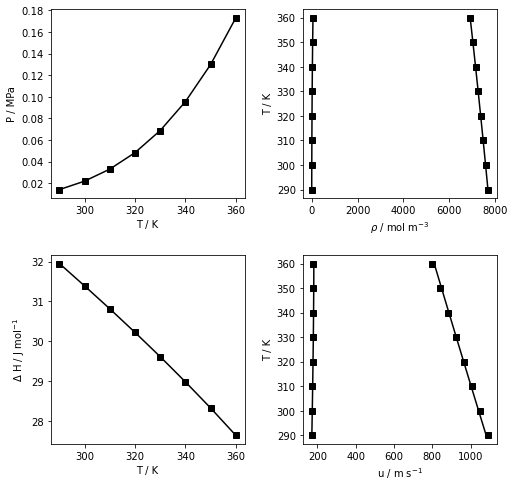

In [10]:
fig = plt.figure(figsize = (8, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

ax = fig.add_subplot(221)
ax.plot(Tsat, P/1e6, color='k')
ax.plot(Tsat, Psat/1e6, 's', color='k')
ax.set_xlabel('T / K')
ax.set_ylabel('P / MPa')

ax2 = fig.add_subplot(222)
ax2.plot(rhosaftl, Tsat, color='k')
ax2.plot(rhosaftv, Tsat, color='k')
ax2.plot(rhol, Tsat, 's', color='k')
ax2.plot(rhov, Tsat, 's', color='k')
ax2.set_ylabel('T / K')
ax2.set_xlabel(r'$\rho$ / mol m$^{-3}$')

ax3 = fig.add_subplot(223)
ax3.plot(Tsat, dHv/1000, color='k')
ax3.plot(Tsat, Hvap/1000, 's', color='k')
ax3.set_xlabel('T / K')
ax3.set_ylabel(r'$\Delta$ H / J mol$^{-1}$')

ax4 = fig.add_subplot(224)
ax4.plot(ul, Tsat, color='k')
ax4.plot(uv, Tsat, color='k')

ax4.plot(speed_liq, Tsat, 's', color='k')
ax4.plot(speed_vap, Tsat, 's', color='k')

ax4.set_ylabel('T / K')
ax4.set_xlabel(r'u / m s$^{-1}$')

## Influence parameter for SGT

If you want to use SGT you need to provide the influence parameter ``cii``, this parameter can be correlated from the molecular parameters for coarse-grained non-associating fluids or can be fitted from experimental interfacial tension data.

To fit the influence parameter you can use the ``fit_cii`` function. This function requires the experimental interfacial tension data and the computed phase equilibria (Tsat, Psat, rhol, rhov).

In [11]:
from SGTPy.fit import fit_cii

fit_cii(iftexp, Tsat, P, rhosaftl, rhosaftv, eos)

3.586172417801607e-19

Now that the influence parameter has been fitted, you can use the ``eos`` object with the ``sgt_pure`` function to compute the IFT of the fluid. 

Then you can compare the results.

In [12]:
from SGTPy.sgt import sgt_pure
pure = component(ms = ms, sigma = sigma , eps = eps, lambda_r = lambda_r , lambda_a = 6., Mw = 86.18,
                 cii=3.5861724177599335e-19)
eos = saftvrmie(pure)

ift = np.zeros_like(iftexp)
for i in range(n):
    ift[i] = sgt_pure(rhosaftv[i], rhosaftl[i], Tsat[i], Psat[i], eos)

C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.8-py3.8-win-amd64.egg\SGTPy\sgt\sgtpure.py:64: RuntimeWarning: invalid value encountered in sqrt
  tenint = np.nan_to_num(np.sqrt(2*dOm))


Text(0, 0.5, '$\\gamma$ / mN m$^{-1}$')

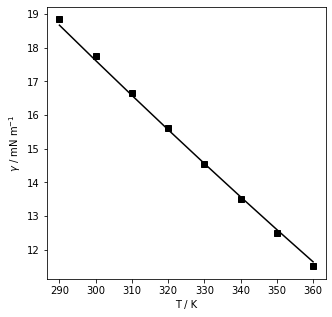

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(Tsat, iftexp, 's', color='k')
ax.plot(Tsat, ift, color='k')
ax.set_xlabel('T / K')
ax.set_ylabel(r'$\gamma$ / mN m$^{-1}$')
